In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import missingno as msno
import tensorflow as tf

# Import from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
import category_encoders as ce
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix, multilabel_confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, plot_roc_curve, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier

import pickle

# Set a random seed
from numpy.random import seed
seed(8)
from tensorflow.random import set_seed
set_seed(8)

# Data Visualization
sns.set_theme(context='notebook', style='darkgrid', palette='viridis')

import warnings
warnings.filterwarnings("ignore")

In [5]:
mood = pd.read_csv('../data/df_moodadj_cluster.csv')
mood.head()

,name,artist,track_id,instrumentalness,danceability,energy,liveness,loudness,acousticness,valence,speechiness,tempo,key,time_signature,length,popularity,mood,mood_map,cluster
0,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,0.000158,0.762,0.701,0.1230,-3.541,0.23500,0.742,0.0286,110.968,8,4,208866,92,Energetic,2,2
1,seaside_demo,SEB,73M0rMVx5CWE8M4uATSsto,0.000133,0.706,0.824,0.1110,-7.959,0.35500,0.860,0.0694,94.980,0,4,132000,54,Energetic,2,2
2,Shivers,Ed Sheeran,6bQfNiqyCX7UaQSvVVGo4I,0.000000,0.788,0.859,0.0424,-2.724,0.28100,0.822,0.0856,141.020,2,4,207853,78,Energetic,2,2
3,Heat Waves,Glass Animals,02MWAaffLxlfxAUY7c5dvx,0.000007,0.761,0.525,0.0921,-6.900,0.44000,0.531,0.0944,80.870,11,4,238805,85,Energetic,2,2
4,Electric Love,BØRNS,2GiJYvgVaD2HtM8GqD9EgQ,0.001370,0.611,0.797,0.2600,-7.627,0.00543,0.518,0.0533,120.041,6,4,218106,82,Energetic,2,2


In [6]:
mood.shape

(5849, 19)

In [7]:
# mood.to_csv('mood_label.csv', index=False)

In [8]:
mood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5849 entries, 0 to 5848
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5849 non-null   object 
 1   artist            5849 non-null   object 
 2   track_id          5849 non-null   object 
 3   instrumentalness  5849 non-null   float64
 4   danceability      5849 non-null   float64
 5   energy            5849 non-null   float64
 6   liveness          5849 non-null   float64
 7   loudness          5849 non-null   float64
 8   acousticness      5849 non-null   float64
 9   valence           5849 non-null   float64
 10  speechiness       5849 non-null   float64
 11  tempo             5849 non-null   float64
 12  key               5849 non-null   int64  
 13  time_signature    5849 non-null   int64  
 14  length            5849 non-null   int64  
 15  popularity        5849 non-null   int64  
 16  mood              5849 non-null   object 


#### **Null model:** 
###### Evaluate class imbalances
###### Classes are fairly balanced

In [9]:
mood['mood'].value_counts(normalize=True)

Energetic    0.472559
Chill        0.283125
Sad          0.244315
Name: mood, dtype: float64

In [10]:
mood[['cluster', 'mood']].groupby('mood')['cluster'].value_counts()

mood       cluster
Chill      2           654
           1           620
           0           382
Energetic  2          2551
           0           202
           1            11
Sad        0           879
           2           440
           1           110
Name: cluster, dtype: int64

#### **Pre-processing**

In [11]:
# make copy of dataframe
mood = mood.copy()

# X audio features
X = mood[['danceability',
          'energy', 
          'loudness', 
          'speechiness', 
          'acousticness',
          'instrumentalness', 
          'liveness', 
          'valence']]

y=mood['mood_map']

#### **Null Model**

In [12]:
y.value_counts(normalize=True)

2    0.472559
1    0.283125
0    0.244315
Name: mood_map, dtype: float64

#### **Pre-processing**

In [16]:
# set up train_test_split with stratification to include equal classes of each
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     stratify=y, 
                                                     random_state=42)

# standardize X data
x = StandardScaler()
X_train_standard = x.fit_transform(X_train)
X_test_standard = x.transform(X_test)

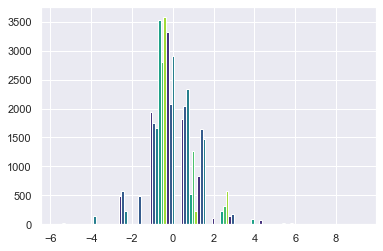

In [40]:
sns.set_theme(context='notebook', style='darkgrid', palette='viridis')
plt.hist(X_train_standard, bins=10);

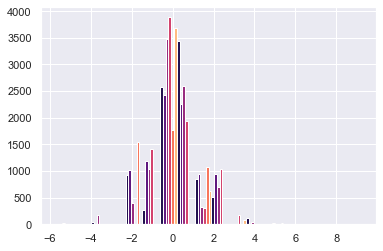

In [52]:
sns.set_theme(context='notebook', style='darkgrid', palette='magma')
plt.hist(X_train_scale, bins=9);

In [18]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ("minmax", MinMaxScaler()),
    ("pc", PCA(n_components=45)),
    ("logreg", LogisticRegressionCV(solver='liblinear', penalty='l1', random_state=42, max_iter=200))])

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.7175102599179206
0.7231715652768285


In [19]:
pickle.dump(pipe, open('../streamlit-app/final_mood_model.pkl', 'wb'))

In [20]:
pipe.classes_

array([0, 1, 2], dtype=int64)

In [21]:
preds = pipe.predict(X_test)

In [22]:
accuracy_score(y_test, preds)

0.7231715652768285

In [23]:
print(f'Sad: {precision_score(y_test, preds, average=None)[0]}')
print(f'Calm: {precision_score(y_test, preds, average=None)[1]}')
print(f'Energetic: {precision_score(y_test, preds, average=None)[2]}')
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='weighted'))

Sad: 0.6332518337408313
Calm: 0.8341708542713567
Energetic: 0.7403508771929824
0.7359245217350568
0.7406926495474437


In [24]:
print(f'Sad: {recall_score(y_test, preds, average=None)[0]}')
print(f'Calm: {recall_score(y_test, preds, average=None)[1]}')
print(f'Energetic: {recall_score(y_test, preds, average=None)[2]}')
print(recall_score(y_test, preds, average='macro'))
print(recall_score(y_test, preds, average='weighted'))

Sad: 0.723463687150838
Calm: 0.40096618357487923
Energetic: 0.9160636758321273
0.6801645155192815
0.7231715652768285


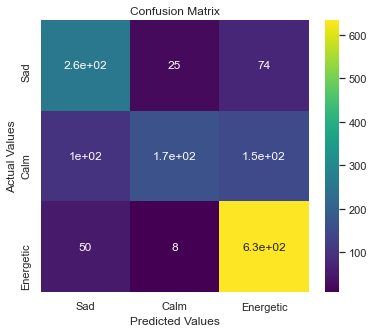

In [25]:
cm = confusion_matrix(y_test, preds, labels=pipe.classes_)
cm_df = pd.DataFrame(cm, index=['Sad', 'Calm', 'Energetic'], columns=['Sad', 'Calm', 'Energetic'])
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [26]:
print(f'Sad: {f1_score(y_test, preds, average=None)[0]}')
print(f'Calm: {f1_score(y_test, preds, average=None)[1]}')
print(f'Energetic: {f1_score(y_test, preds, average=None)[2]}')

Sad: 0.6753585397653195
Calm: 0.5415986949429038
Energetic: 0.8188874514877101


In [27]:
print(f"Macro: {f1_score(y_test, preds, average='macro')}")
print(f"Weighted: {f1_score(y_test, preds, average='weighted')}")

Macro: 0.6786148953986445
Weighted: 0.7052983225703037


In [28]:
pred_df = pd.DataFrame({'true_values'     : y_test,
                        'prediction_prob' : pipe.predict_proba(X_test)[:,1]})

In [29]:
pred_df.head(30)

,true_values,prediction_prob
4737,2,0.045527
1799,0,0.204300
2681,2,0.117677
2571,2,0.116292
3819,1,0.098390
2850,2,0.133025
1719,0,0.287853
2678,2,0.277806
632,2,0.249139
4318,0,0.226824


In [30]:
# Generate class membership probabilities
y_pred_probs = pipe.predict_proba(X_test)

roc_curve_weighted=roc_auc_score(y_test, y_pred_probs, average="weighted", multi_class="ovr")
roc_curve_macro=roc_auc_score(y_test, y_pred_probs, average='macro', multi_class="ovr")
print(roc_curve_weighted)
print(roc_curve_macro)

0.8631056954734205
0.85650827850034


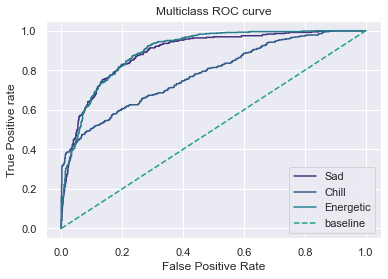

In [31]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_probs[:,i], pos_label=i)
    
# plotting  
sns.set_palette('viridis')
plt.plot(fpr[0], tpr[0], linestyle='-',label='Sad')
plt.plot(fpr[1], tpr[1], linestyle='-',label='Chill')
plt.plot(fpr[2], tpr[2], linestyle='-',label='Energetic')

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC.png');  

In [71]:
def audio_analysis(playlist_id):    
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

    # user credentials
    client_id = 'a71512db396c4f9f9132928928f9ddff'
    client_secret = '66041252b1f44debae39f3e09953dd74'
    redirect_url = 'https://www.google.com'
    user_id = "bsanzone225"
    genius_access_token = "F_FuandD31vRz1yy6nXxXyeK4eNw6fIlFzGN72_PJRgQkhE294AIk3m_jGUHd03E"
    scope_playlist = 'playlist-read-private'
    
    # get user authorization
    user_auth_manager = SpotifyOAuth(scope=scope_playlist,client_id=client_id,client_secret=client_secret,username=user_id, redirect_uri=redirect_url)
    sp = spotipy.Spotify(auth_manager=user_auth_manager)
    
    # get list of track ids in playlist
    playlist = sp.playlist_tracks(playlist_id)
    song_ids = []
    for result in playlist['tracks']['items']:
        song_ids.append(result['track']['id'])
    
    features_data = []
    
    for track in song_ids:
        audio_features_list = sp.audio_features(tracks=track)

        for feature in audio_features_list:
        
            acousticness = feature['acousticness']
            danceability = feature['danceability']
            energy = feature['energy']
            instrumentalness = feature['instrumentalness']
            liveness = feature['liveness']
            valence = feature['valence']
            loudness = feature['loudness']
            speechiness = feature['speechiness']
            tempo = feature['tempo']
            key = feature['key']
            time_signature = feature['time_signature']
            track_id = feature['id']
            track = sp.track(track_id)
            name = track['name']
            artist = track['artists'][0]['name']
            length = track['duration_ms']
            popularity = track['popularity']
            features_data.append([name, 
                                  artist, 
                                  track_id, 
                                  instrumentalness, 
                                  danceability, 
                                  energy, 
                                  liveness, 
                                  loudness, 
                                  acousticness, 
                                  valence, 
                                  speechiness,
                                  tempo, 
                                  key,
                                  time_signature,
                                  length,
                                  popularity])
    df = pd.DataFrame(features_data, columns = ['name', 
                                                'artist', 
                                                'track_id', 
                                                'instrumentalness', 
                                                'danceability', 
                                                'energy', 
                                                'liveness', 
                                                'loudness', 
                                                'acousticness', 
                                                'valence', 
                                                'speechiness',
                                                'tempo', 
                                                'key',
                                                'time_signature',
                                                'length',
                                                'popularity'])
    
    X_audio = df[['danceability', 
       'energy', 
       'loudness', 
       'speechiness', 
       'acousticness',
       'instrumentalness', 
       'liveness', 
       'valence', 
       'tempo',
       'key']]
    
    xc = StandardScaler()
    X = xc.fit_transform(X_audio)
    
    km = KMeans(n_clusters=2)
    km.fit(X)
    df['vibe'] = km.labels_
    
    X = df[['danceability', 
           'energy', 
           'loudness', 
           'speechiness', 
           'acousticness',
           'instrumentalness', 
           'liveness', 
           'valence', 
           'tempo',
           'key',
           'vibe']]
    
    
    pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ("minmax", MinMaxScaler()),
    ("pc", PCA(n_components=32)),
    ("logreg", LogisticRegressionCV(multi_class='multinomial', random_state=42, max_iter=50))])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X)
    preds_list=[x for x in preds]
    
    n = len(preds_list)
    sad = []
    chill = []
    energetic = []
    
    for pred in preds_list:
        if pred == 0:
            sad.append(pred)
    for pred in preds_list:
        if pred == 1:
            chill.append(pred)
    for pred in preds_list:
        if pred == 2:
            energetic.append(pred)
            
    n_sad = len(sad)
    n_chill = len(chill)
    n_energetic = len(energetic)
    return print(f'This playlist is {np.round((n_sad/(n))*100,0)}% Sad, {np.round((n_chill/(n))*100,0)}% Chill, and {np.round((n_energetic/(n))*100,0)}% Energetic')


In [72]:
audio_analysis(playlist_id='7od0I5IC3GfzXeGj3i6ugy?si=c67a8ca3029a4005')

This playlist is 0.0% Sad, 33.0% Chill, and 67.0% Energetic


In [74]:
pickle.dump(audio_analysis, open('../streamlit-app/playlist_predict_mood.pkl', 'wb'))

In [354]:
np.array(X).reshape(-1,1)

array([[  0.762],
       [  0.701],
       [ -3.541],
       ...,
       [140.179],
       [  0.   ],
       [  0.   ]])